# Exercise 2: Supervised Learning

Extension of https://oist.github.io/BrainComputation/Supervised.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### 1. Online Linear Regression

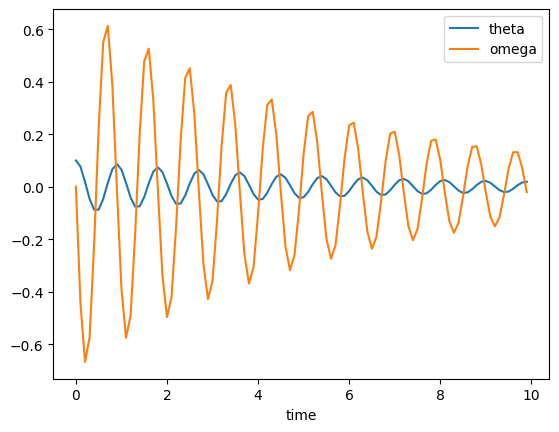

In [7]:
l = 0.3   # arm length: m
th = 1.5  # angle: rad (note the large initial deviation)
m = 5     # arm mass: kg
mu = 0.05  # damping: Nm/(rad/s)
g = 9.8   # gravity: N/s^2
I = (m*l**2)/3 # inertia for a rod around an end: kg m^2
def arm(x, t):
    """arm dynamics for odeint: x=[th,om]"""
    th, om = np.array(x)  # for readability
    # angular acceleration
    aa = (-m*g*l/2*np.sin(th) - mu*om)/I
    return np.array([om, aa])
dt = 0.1  # time step
t = np.arange(0, 10, dt)  # time points
X = odeint(arm, [0.1, 0], t)
plt.plot(t, X)
plt.xlabel("time")
plt.legend(("theta","omega"));

Text(0.5, 0.5, 'omega')

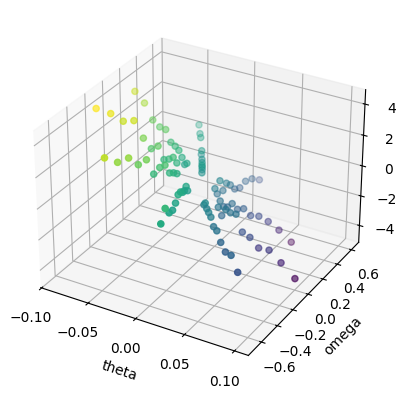

In [8]:
# acceleration by differentiation
Y = (X[1:,1] - X[:-1,1])/dt  # temporal difference
X = X[:-1,:]    # omit the last point
N, D = X.shape  # data count and dimension
# add observation noise
sig = 0.25      # noise size (set to be small to ensure dominance of non-linearity)
Y = Y + sig*np.random.randn(N)
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y, c=Y)
plt.xlabel("theta"); plt.ylabel("omega")

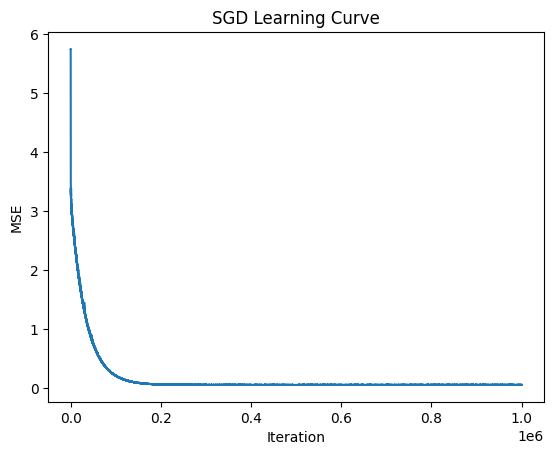

In [23]:
# angular acceleration is a non-linear function of theta and angular velocity
# but we will try fitting to it using linear regression (as estimated by sgd)
X1 = np.hstack((np.ones((N, 1)), X)) # data matrix
w = np.random.randn(D+1) # regression weights
alpha = 1e-2
num_iters = 1_000_000
mse = np.zeros(num_iters)
for i in range(num_iters):
    idx = np.random.randint(0, N)
    x_n = X1[idx]
    y_true = Y[idx]
    y_pred = np.dot(w, x_n)
    # sgd
    y_pred = np.dot(w, x_n)
    error = y_pred - y_true
    w -= alpha * error * x_n
    # compute error
    preds = X1.dot(w)
    mse[i] = np.mean((preds - Y) ** 2)
plt.figure()
plt.plot(np.arange(num_iters), mse)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("SGD Learning Curve")
plt.show()

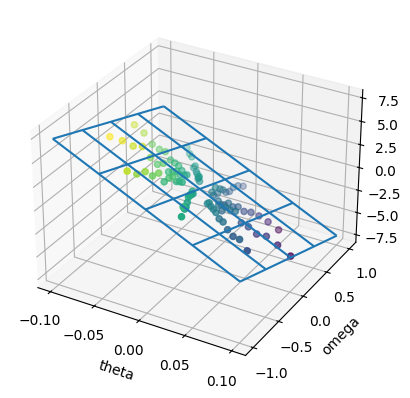

In [24]:
# show regression surface
ax = plt.figure().add_subplot(111, projection='3d')
# make a grid
X2, Y2 = np.meshgrid(np.linspace(-0.1,0.1,5),np.linspace(-1,1,5))
# show wireframe
Z2 = w[0] + w[1]*X2 + w[2]*Y2
ax.plot_wireframe(X2, Y2, Z2);
# show the data
ax.scatter(X[:,0], X[:,1], Y, c=Y);
plt.xlabel("theta"); plt.ylabel("omega");

In [25]:
# comparison with batch linear regression (closed form)
w_sgd = w.copy()
mse_sgd = np.mean((X1 @ w_sgd - Y) ** 2)
w_closed = np.linalg.inv(X1.T @ X1) @ (X1.T @ Y)
mse_closed = np.mean((X1 @ w_closed - Y) ** 2)
print("SGD weights:     ", w_sgd)
print("SGD MSE:         ", mse_sgd)
print("Closed-form w:   ", w_closed)
print("Closed-form MSE: ", mse_closed)
print("‖w_sgd - w_closed‖^2 =", np.linalg.norm(w_sgd - w_closed))
print("ΔMSE = ", mse_sgd - mse_closed)

SGD weights:      [ 3.58723995e-04 -4.54353085e+01 -2.75462337e+00]
SGD MSE:          0.059377565392109026
Closed-form w:    [ 3.06617219e-03 -4.54313615e+01 -2.76636402e+00]
Closed-form MSE:  0.05935982240737282
‖w_sgd - w_closed‖^2 = 0.012678803574645646
ΔMSE =  1.774298473620345e-05


### 2. Linear Regression with Gaussian Basis Functions

In [ ]:
# 2D gaussians over X: we get a better fit!
ncenters = 7
c1 = np.linspace(-1.0, 1.0, ncenters)  # centers along theta
c2 = np.linspace(-1.0, 1.0, ncenters)  # centers along omega (theta dot)
centers = np.array([[a, b] for a in c1 for b in c2])
sigma = (c1[1] - c1[0])/2 # sd = half width bw centers
diff = X[:, None, :] - centers[None, :, :]
dist2 = np.sum(diff ** 2, axis=2)
phi = np.exp(-dist2 / (2 * sigma**2)) # (N, ncenters)
phi1 = np.hstack((np.ones((N, 1)), phi))
w_rbf = np.linalg.inv(phi1.T @ phi1) @ (phi1.T @ Y)
mse_rbf = np.mean((phi1 @ w_rbf - Y) ** 2)
print("RBF MSE: ", mse_rbf)
print("ΔMSE = ", mse_rbf - mse_closed)

RBF MSE:  0.03236550295850123
ΔMSE =  -0.026994319448871595


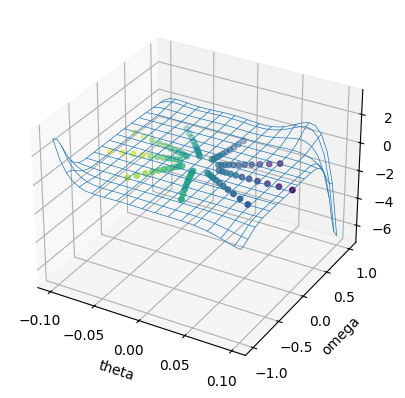

In [ ]:
# notice how the predicted grid space falls on a "flat" sheet now
th, om = np.meshgrid(np.linspace(-0.1,0.1,30),np.linspace(-1,1,30))
grid_pts = np.column_stack((th.ravel(), om.ravel()))
diff = grid_pts[:, None, :] - centers[None, :, :]
dist2 = np.sum(diff**2, axis=2)
phis = np.exp(-dist2 / (2 * sigma**2))
phis1 = np.hstack((np.ones((phis.shape[0], 1)), phis))
Z = (phis1 @ w_rbf).reshape(30, 30)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(th, om, Z, rstride=2, cstride=2, linewidth=0.5)
ax.scatter(X[:, 0], X[:, 1], Y, c=Y, cmap='viridis', s=15)
ax.set_xlabel("theta"); ax.set_ylabel("omega"); ax.set_zlabel("acceleration")
plt.show()

### 3. Online Logistic Regressesion

$$\nabla_\mathbf{w}E(\mathbf{w}) = \left(\sigma(\mathbf{w}^\top\mathbf{x}_n) - y_n\right)\mathbf{x}_n$$

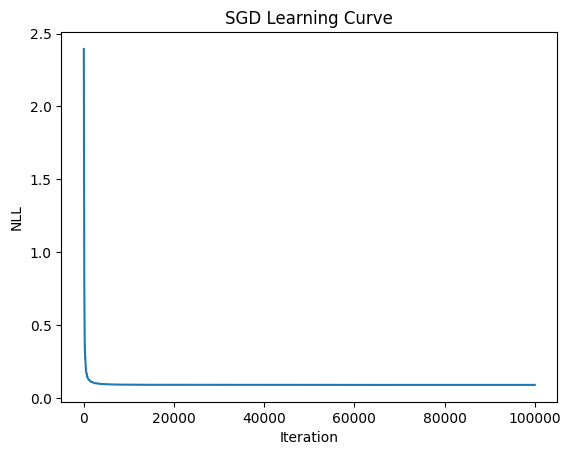

In [63]:
N = 100 # number of samples
D = 2   # feature dimension (excluding bias)

# generate features from two gaussians
X_pos = np.random.randn(N // 2, D) + np.array([1.35, 1.35])
X_neg = np.random.randn(N // 2, D) + np.array([-1.35, -1.35])
X = np.vstack((X_pos, X_neg)) # data points
Y = np.hstack((np.ones(N // 2), np.zeros(N // 2))) # labels

# shuffle the data
perm = np.random.permutation(N)
X = X[perm]
Y = Y[perm]

# sgd for logistic regression
X1 = np.hstack((np.ones((N, 1)), X)) # data matrix
w = np.random.randn(D + 1)
alpha = 1e-2
num_iters = 100_000
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

logloss = np.zeros(num_iters)
for i in range(num_iters):
    idx = np.random.randint(0, N)
    x_n = X1[idx]
    y_n = Y[idx]
    z = w.dot(x_n)
    p = sigmoid(z) # p(y=1|x_n)
    grad_w = (p - y_n) * x_n
    w -= alpha * grad_w
    probs = sigmoid(X1.dot(w))
    probs = np.clip(probs, 1e-8, 1.0 - 1e-8) # numeric stability
    logloss[i] = -np.mean(Y * np.log(probs) + (1 - Y) * np.log(1 - probs))
plt.figure()
plt.plot(np.arange(num_iters), logloss)
plt.xlabel("Iteration")
plt.ylabel("NLL")
plt.title("SGD Learning Curve")
plt.show()

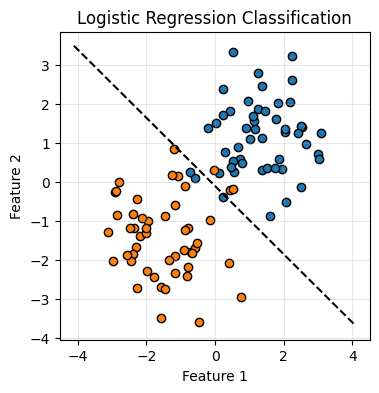

In [68]:
# data points colored by label
plt.figure(figsize=(4, 4))
mask_pos = Y == 1
mask_neg = Y == 0
plt.scatter(X[mask_pos, 0], X[mask_pos, 1], c="tab:blue", edgecolor="k")
plt.scatter(X[mask_neg, 0], X[mask_neg, 1], c="tab:orange", edgecolor="k")
# decision boundary: w0 + w1*x + w2*y = 0 → y = −(w0 + w1 x)/w2
x_vals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
if abs(w[2]) > 1e-8:
    y_vals = - (w[0] + w[1] * x_vals) / w[2]
    plt.plot(x_vals, y_vals, 'k--', linewidth=1.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Classification")
plt.grid(alpha=0.3)
plt.show()